In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from dataclasses import asdict
from datetime import datetime
import cartopy.crs as ccrs
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal, mindelo, find_ec_lon, vertical_preview, to_kml, ec_time_at_lat

# Global coordinates and definitions that should not change from flight to flight

lon_min, lon_max, lat_min, lat_max = -65, -5, -5, 25

radius = 133e3
atr_radius = 70e3

band = "east"
airport = sal if band == "east" else bco
natal = LatLon(-5 - 47/60. - 42.00/3600.,-35 - 12/60. - 33.98/3600., label = "natal")

In [20]:
# Basic information
lon_min, lon_max, lat_min, lat_max = -65, -5, -5, 25

# Define dates for forecast initialization and flight

issued_time = datetime(2024, 8, 27, 0, 0, 0)

flight_time = datetime(2024, 8, 31, 12, 0, 0)
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

# adjust takeoff time to match EC overpass
takeoff_time = np.datetime64("2025-08-29T12:20:00.0")

print(
    f"Initalization date of IFS forecast: {issued_time}\n"
    f"Flight date: {flight_time:%Y-%m-%d}\n"
    f"Flight index: {flight_index}"
)

crew = {'Mission PI': 'Silke Groß',
        'DropSondes': 'Theresa Mieslinger',
        'HAMP': 'Jakob Deutloff',
        'SMART/VELOX': 'tbd',
        'SpecMACS': 'tbd',
        'WALES' : 'Julia Windmiller',
        'Flight Documentation': 'tbd',
        'Ground Support': 'tbd',
        }

Initalization date of IFS forecast: 2024-08-27 00:00:00
Flight date: 2024-08-31
Flight index: HALO-20240831a


In [21]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(datetime = issued_time).to_dask().pipe(egh.attach_coords)

# Load ec satellite track for 
ec_track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-26", kind="PRE").get_track_for_day(f"{flight_time:%Y-%m-%d}")
ec_track = ec_track.sel(time=slice(f"{flight_time:%Y-%m-%d} 06:00", None))
ec_lons, ec_lats = ec_track.lon.values, ec_track.lat.values

**Waypoint definitions**

In [22]:
# Latitudes where we enter and leave the ec track (visually estimated)
lat_ec_north_in = sal.lat
lat_ec_south = 1.0
lat_ec_shuttle_in = 16.0
lat_ec_shuttle_out = 14.0

# latitude of circle centers
lat_c_north = 11.5

lat_c_south = 4.0
lat_c_south_n = lat_c_south + 1.0
lat_c_south_s = lat_c_south - 1.0

lat_c_mid = lat_c_south + (lat_c_north-lat_c_south)/2.0
lat_c_mid_n = lat_c_mid + 1.0
lat_c_mid_s = lat_c_mid - 1.0

lat_ec_under = 13.0

lat_c_atr = lat_ec_shuttle_out + atr_radius/111e3
#c_atr_nw = LatLon(17.433,-23.500, label = "c_atr")
#c_atr_se = LatLon(16.080,-21.715, label = "c_atr")

c_atr_nw = LatLon(18.58125000,-24.27616667, label = "c_atr")
c_atr_se = LatLon(15.79318333,-24.82891944, label = "c_atr")

# create ec track
ec_north = LatLon(lat_ec_north_in, find_ec_lon(lat_ec_north_in, ec_lons, ec_lats), label = "ec_north")
ec_south = LatLon(lat_ec_south, find_ec_lon(lat_ec_south, ec_lons, ec_lats), label = "ec_south")

# create shuttle track
ec_shuttle_in = LatLon(lat_ec_shuttle_in, find_ec_lon(lat_ec_shuttle_in, ec_lons, ec_lats), label = "ec_shuttle_in")
ec_shuttle_out = LatLon(lat_ec_shuttle_out, find_ec_lon(lat_ec_shuttle_out, ec_lons, ec_lats), label = "ec_shuttle_out")

# create circles
c_north = LatLon(lat_c_north, find_ec_lon(lat_c_north, ec_lons, ec_lats), label = "c_north")

c_south = LatLon(lat_c_south, find_ec_lon(lat_c_south, ec_lons, ec_lats), label = "c_south")
c_south_s = LatLon(lat_c_south_s, find_ec_lon(lat_c_south_s, ec_lons, ec_lats), label = "c_south_s")
c_south_n = LatLon(lat_c_south_n, find_ec_lon(lat_c_south_n, ec_lons, ec_lats), label = "c_south_n")

c_mid = LatLon(lat_c_mid, find_ec_lon(lat_c_mid, ec_lons, ec_lats), label = "c_mid")
c_mid_s = LatLon(lat_c_mid_s, find_ec_lon(lat_c_mid_s, ec_lons, ec_lats), label = "c_mid_s")
c_mid_n = LatLon(lat_c_mid_n, find_ec_lon(lat_c_mid_n, ec_lons, ec_lats), label = "c_mid_n")

c_atr = LatLon(lat_c_atr, find_ec_lon(lat_c_atr, ec_lons, ec_lats), label = "c_atr")

# ec underpass
ec_under = LatLon(lat_ec_under, find_ec_lon(lat_ec_under, ec_lons, ec_lats), label = "ec_under")
ec_under = ec_under.assign(time=str(ec_time_at_lat(ec_track, ec_under.lat).values)+"Z")

# Define flight track
outbound_legs = [
     airport.assign(fl=0),
     ec_north.assign(fl=410),
     ec_south.assign(fl=410),
     ]

ec_legs = [
     IntoCircle(c_south.assign(fl=410), radius, 360),        
     IntoCircle(c_mid.assign(fl=430), radius, 360), 
     IntoCircle(c_north.assign(fl=430), radius, 360),   
     ec_under.assign(fl=430),
     ]
inbound_legs = [
     ec_shuttle_out.assign(fl=450),
     ec_shuttle_in.assign(fl=450),
     ec_shuttle_out.assign(fl=350),
     IntoCircle(c_atr.assign(fl=350), atr_radius, 360), 
#     IntoCircle(c_atr_nw.assign(fl=350), atr_radius, 360),
#     IntoCircle(c_atr_se.assign(fl=350), atr_radius, 360),
     airport.assign(fl=0),
     ]

waypoints = outbound_legs + ec_legs + inbound_legs 

waypoint_centers = []
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
    waypoint_centers.append(point)

path = fp.expand_path(waypoints, dx=10e3)

In [23]:
plan = path.isel(distance = path.waypoint_indices).to_dataframe().set_index("waypoint_labels")
plan

,waypoint_indices,distance,lon,lat,fl,speed,duration,time
waypoint_labels,,,,,,,,
SAL,0,0.000000e+00,-22.943974,16.734488,0.0,180.724333,0 days 00:00:00,2024-08-31 08:50:23.669180120
ec_north,12,1.148639e+05,-21.866800,16.734488,410.0,234.380889,0 days 00:09:45.268462214,2024-08-31 09:00:08.937642334
ec_south,190,1.885819e+06,-24.857126,1.000000,410.0,234.380889,0 days 02:15:41.153932752,2024-08-31 11:06:04.823112872
c_south_in,211,2.090330e+06,-24.518511,2.817863,410.0,234.380889,0 days 02:30:13.712132884,2024-08-31 11:20:37.381313004
c_south_out,298,2.924300e+06,-24.518511,2.817863,410.0,234.380889,0 days 03:29:31.894620302,2024-08-31 12:19:55.563800422
c_mid_in,341,3.346244e+06,-23.817458,6.568157,430.0,236.541556,0 days 03:59:23.895668207,2024-08-31 12:49:47.564848327
c_mid_out,428,4.180214e+06,-23.817458,6.568157,430.0,236.541556,0 days 04:58:09.576316547,2024-08-31 13:48:33.245496667
c_north_in,471,4.602275e+06,-23.109244,10.318619,430.0,236.541556,0 days 05:27:53.876069294,2024-08-31 14:18:17.545249414
c_north_out,558,5.436245e+06,-23.109244,10.318619,430.0,236.541556,0 days 06:26:39.556791002,2024-08-31 15:17:03.225971122


In [24]:
# extra way points off track

plan = path.isel(distance = path.waypoint_indices).to_dataframe().set_index("waypoint_labels")


xwp_2 = LatLon(lat_c_south-1, find_ec_lon(lat_c_south-1, ec_lons, ec_lats), label = "xwp2")
xwp_3 = LatLon(c_atr_nw.lat,c_atr_nw.lon, label = "xwp3")
extra_waypoints = [xwp_2,xwp_3]

notes = {'c_south_in':f' {radius/1852:2.0f} nm circle centered at {c_south.format_pilot()}, enter from north, CCW',
        'c_mid_in':f' {radius/1852:2.0f} nm circle centered at {c_mid.format_pilot()}, enter from north, CCW',
        'c_north_in':f' {radius/1852:2.0f} nm circle centered at {c_north.format_pilot()}, enter from south, CCW',
        'c_atr_in':f' {atr_radius/1852:2.0f} nm circle centered at {c_atr_se.format_pilot()}, enter from west, CW',
        'xwp2':'Alternative center for c_south',
        'xwp3':'Alternative center for c_atr',
         }


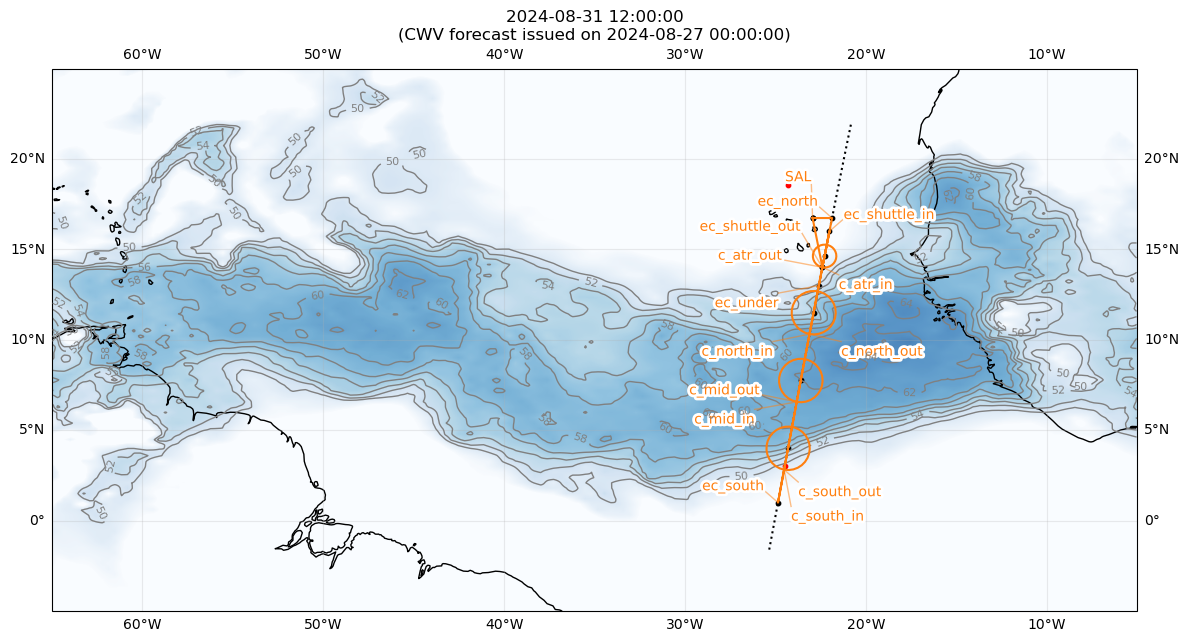

In [25]:
plt.figure(figsize = (14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [50.0, 52.0, 54.0, 56.0, 58.0, 60.0, 62.0, 64.0,])
plt.title(f"{flight_time}\n(CWV forecast issued on {issued_time})")

plt.plot(ec_lons, ec_lats, c='k', ls='dotted')

if (False):
    plt.plot([natal.lon,sal.lon], [natal.lat,sal.lat], c='purple', ls='dashed')

for wp in waypoint_centers:
    plt.scatter(wp.lon,wp.lat,s=10.,color='k')
for wp in extra_waypoints:
    plt.scatter(wp.lon,wp.lat,s=10.,color='r',marker='o')
fp.plot_path(path, ax, color="C1")
plt.savefig(f'{flight_index}_track.png', bbox_inches='tight')

In [26]:
import pandas as pd

In [27]:
pd.DataFrame.from_records(map(asdict, [mindelo, 
                                       ec_north,
                                       ec_south,
                                       c_atr_nw,
                                       c_atr_se,
                                       ec_under,
                                       c_north,
                                       c_mid_n,
                                       c_mid_s,
                                       c_mid,
                                       c_south_n,
                                       c_south_s,
                                       c_south,
                                       mindelo
                                      ])).set_index("label")

,lat,lon,fl,time
label,,,,
MINDELO,16.877810,-24.995002,0.0,NaT
ec_north,16.734488,-21.866800,NaN,NaT
ec_south,1.000000,-24.857126,NaN,NaT
c_atr,18.581250,-24.276167,NaN,NaT
c_atr,15.793183,-24.828919,NaN,NaT
ec_under,13.000000,-22.594854,NaN,2024-08-31 15:38:19.404320+00:00
c_north,11.500000,-22.882870,NaN,NaT
c_mid_n,8.750000,-23.405780,NaN,NaT
c_mid_s,6.750000,-23.782732,NaN,NaT


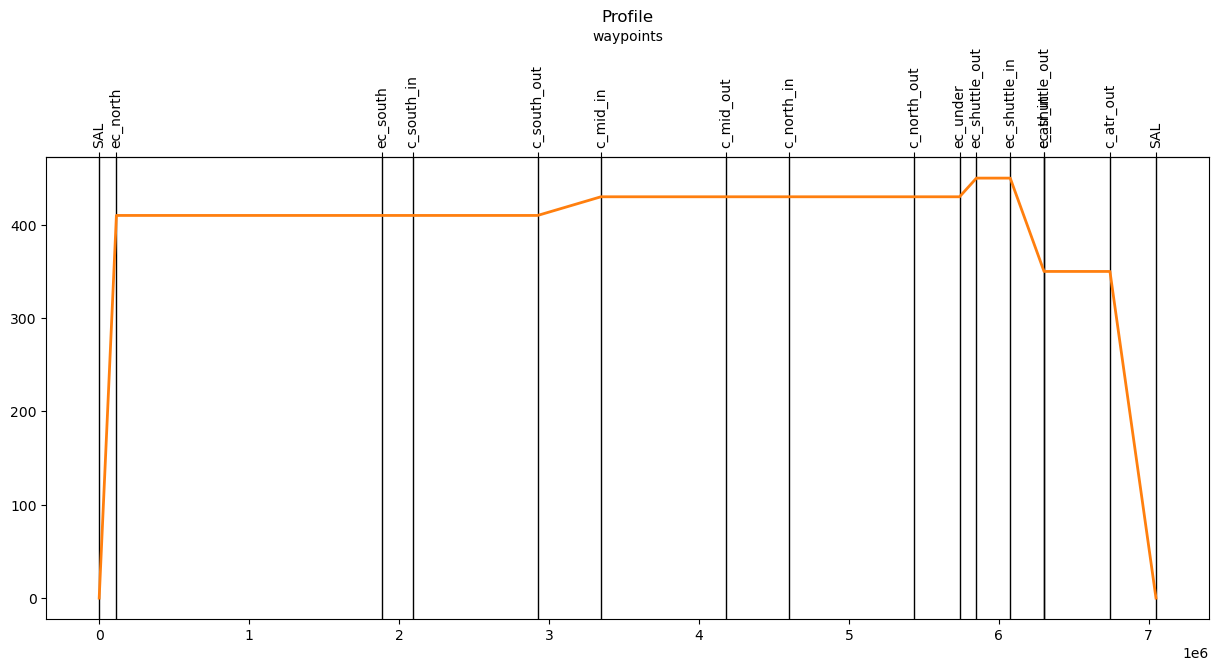

In [28]:
vertical_preview(waypoints)
plt.title("Profile")
plt.savefig(f'{flight_index}_profile.png')

In [29]:
# Detailed overview with notes
for index, row in plan.iterrows():
    if (index[0]+index[-4:]!='c_out'):
        print(f"{index:12s} {LatLon(row['lat'],row['lon']).format_pilot():20s}, FL{int(row['fl']):03d}, {row['time']:%H:%M:%S}, {notes.get(index,'')}" )
print ('\n-- circle centers:')
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
        print (f'{point.label:12s} {point.format_pilot()}')
print ('\n-- extra waypoints:')
for point in extra_waypoints:
    print (f'{point.label:12s} {point.format_pilot()}, {notes.get(point.label,'')}' )
print ('\nCrew:')
for position,person in crew.items():
    print (f'{position:22s} {person}')

SAL          N16 44.07, W022 56.64, FL000, 08:50:23, 
ec_north     N16 44.07, W021 52.01, FL410, 09:00:08, 
ec_south     N01 00.00, W024 51.43, FL410, 11:06:04, 
c_south_in   N02 49.07, W024 31.11, FL410, 11:20:37,  72 nm circle centered at N04 00.00, W024 17.87, enter from north, CCW
c_mid_in     N06 34.09, W023 49.05, FL430, 12:49:47,  72 nm circle centered at N07 45.00, W023 35.67, enter from north, CCW
c_north_in   N10 19.12, W023 06.55, FL430, 14:18:17,  72 nm circle centered at N11 30.00, W022 52.97, enter from south, CCW
ec_under     N13 00.00, W022 35.69, FL430, 15:38:19, 
ec_shuttle_out N14 00.00, W022 24.09, FL450, 15:46:13, 
ec_shuttle_in N16 00.00, W022 00.68, FL450, 16:01:58, 
ec_shuttle_out N14 00.00, W022 24.09, FL350, 16:18:05, 
c_atr_in     N14 00.54, W022 23.99, FL350, 16:18:10,  38 nm circle centered at N15 47.59, W024 49.74, enter from west, CW
SAL          N16 44.07, W022 56.64, FL000, 17:17:20, 

-- circle centers:
c_south      N04 00.00, W024 17.87
c_mid        N

### Export kml and text file for FX and pilots

In [30]:
with open(f"{flight_index}.kml", "w") as f:
    f.write(to_kml(path))

In [31]:
with open( f"{flight_index}_waypoints.txt", "w") as file:
    file.write(f"Flight {flight_index}\n\n")
    #
    # DM Format
    file.write("------------------------------------------------------------\n")
    file.write("\nDM Format:\n")
    file.write(" ".join(wp.format_1min() for wp in waypoint_centers) + "\n")
    for point in extra_waypoints:
        file.write(f"Extra waypoint: {point.format_1min()}\n")
    #
    # DM.mm format
    file.write("\n------------------------------------------------------------\n")
    file.write("\nDMmm Format:\n")
    for point in waypoint_centers:
        file.write(f"{point.format_pilot()}, {point.label}\n")
    file.write("\n-- extra waypoints:\n")
    for point in extra_waypoints:
        file.write(f"{point.format_pilot()}, {notes.get(point.label,'')}\n")
    #
    # Detailed overview with notes
    file.write("\n------------------------------------------------------------\n")
    file.write(f"\n\nDetailed Overview:\n")
    for index, row in plan.iterrows():
        if (index[0]+index[-4:]!='c_out'):
            file.write(f"{index:12s} {LatLon(row['lat'],row['lon']).format_pilot():20s}, FL{int(row['fl']):03d}, {takeoff_time+row['duration']:%H:%M:%S}, {notes.get(index,'')}\n" )
    file.write ('\n -- circle centers:')
    for point in waypoints:
        if isinstance(point, IntoCircle):
            point = point.center
            file.write (f'\n{point.label:12s} {point.format_pilot()}')
    file.write ('\n\n -- extra waypoints:')
    for point in extra_waypoints:
        file.write (f'\n{point.label:12s} {point.format_pilot()}, {notes.get(point.label,'')}' )
    file.write ('\n\nCrew:')
    for position,person in crew.items():
        file.write (f'\n{position:22s} {person}')


In [32]:
waypoint_centers

[LatLon(lat=16.73448797020352, lon=-22.94397423993749, label='SAL', fl=0, time=None),
 LatLon(lat=16.73448797020352, lon=np.float64(-21.866800401195103), label='ec_north', fl=410, time=None),
 LatLon(lat=1.0, lon=np.float64(-24.857126133909286), label='ec_south', fl=410, time=None),
 LatLon(lat=4.0, lon=np.float64(-24.297776334464672), label='c_south', fl=410, time=None),
 LatLon(lat=7.75, lon=np.float64(-23.594582227707498), label='c_mid', fl=430, time=None),
 LatLon(lat=11.5, lon=np.float64(-22.88286975308642), label='c_north', fl=430, time=None),
 LatLon(lat=13.0, lon=np.float64(-22.59485401234568), label='ec_under', fl=430, time=datetime.datetime(2024, 8, 31, 15, 38, 19, 404320, tzinfo=datetime.timezone.utc)),
 LatLon(lat=14.0, lon=np.float64(-22.401539981475764), label='ec_shuttle_out', fl=450, time=None),
 LatLon(lat=16.0, lon=np.float64(-22.011364885731933), label='ec_shuttle_in', fl=450, time=None),
 LatLon(lat=14.0, lon=np.float64(-22.401539981475764), label='ec_shuttle_out', 